In [1]:
import string
import numpy as np
import PIL.Image

from os import listdir
from pickle import dump, load

from numpy import array
from numpy import argmax

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Image, display


# 1. Preparing Image Data

In [48]:
# Extract features from each photo in the directory
def extract_features(directory):
    model = VGG16()
    # Removing the last layer from the loaded model as we require only the features not the classification 
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
    return features

In [3]:
# Defining the directory we are using
directory = './Flicker_Data/Images'

# Extracting features from all the images
features = extract_features(directory)

print('Extracted Features: ', len(features))

# Dumping the features in a pickle file for further use
dump(features, open('extracted_features.pkl', 'wb'))

182116352/553467096 [========>.....................] - ETA: 44:07

# 2. Preparing Text Data
--> From the Flickr_token.txt file clean the captions and store it in required form(descriptions.txt) used for our training.. )

--> From the descriptions.txt file create vocabulary of the corpus..


In [4]:
def image_description_mapping(descriptions):
    
    description_mapping = dict()
    for line in descriptions.split('\n'):
        words = line.split()
        if len(line)<2:
            continue
        image_id, image_description = words[0], words[1:]
        image_id = image_id.split('.')[0]
        image_description = ' '.join(image_description)
        if image_id not in description_mapping:
            description_mapping[image_id] = list()
            
        description_mapping[image_id].append(image_description)
    
    return description_mapping

In [5]:
def clean_descriptions(description_mapping):

    # Preapring a translation table for removing all the punctuation
    table = str.maketrans('','', string.punctuation)
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):
            description = descriptions[i]
            description = description.split()
            
            # Converting all the words to lower case
            description = [word.lower() for word in description]
            
            # Removing the punctuation using the translation table we made
            description = [word.translate(table) for word in description]
            
            # Removing the words with length =1
            description = [word for word in description if len(word)>1]
            
            # Removing all words with number in them
            description = [word for word in description if word.isalpha()]
            
            descriptions[i] = ' '.join(description)

In [7]:
filename = './Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

# Loading descriptions..
file = open(filename, 'r')
doc = file.read()
file.close()

# Build a dictionary of photo identifiers to the descriptions..
descriptions = image_description_mapping(doc)

# Cleaning the descriptions
clean_descriptions(descriptions)

# Summarizing the vocabulary
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

# Saving to the file
filename = "descriptions.txt"
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
data = '\n'.join(lines)
file = open(filename, 'w')
file.write(data)
file.close()

Vocabulary Size: 8763


# 3. Building Deep Learning Model

### --> loading train data to train the model

In [8]:
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Function for loading a pre-defined list of photo identifiers
def load_photo_identifiers(filename):
    file = load_file(filename)
    photos = list()
    for line in file.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        photos.append(identifier)
    return set(photos)

def load_clean_descriptions(filename, photos):
    file = load_file(filename)
    descriptions = dict()
    for line in file.split('\n'):
        words = line.split()
        image_id, image_description = words[0], words[1:]
        if image_id in photos:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

# function to load the photo features created using the VGG16 model
def load_photo_features(filename, photos):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in photos}
    
    return features

In [9]:
filename = './Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'

train = load_photo_identifiers(filename)
print('Train Dataset: ',len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Loaded Train Descriptions: ', len(train_descriptions))

train_features = load_photo_features('extracted_features.pkl', train)
print('Loaded Train image features: ', len(train_features))
print("Size of feature of a image: ",train_features['2131762850_5293a288d9'].shape)


Train Dataset:  6000
Loaded Train Descriptions:  6000
Loaded Train image features:  6000
Size of feature of a image:  (1, 4096)


### --> tokenizing train descriptions

In [10]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Given the descriptions, fit a tokenizer
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

#calculated the length of description with most words
def max_des_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [11]:
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Train Vocabulary Size: ', vocab_size)

max_length = max_des_length(train_descriptions)
print('Maximum Description Length: ', max_length)

Train Vocabulary Size:  7579
Maximum Description Length:  34


### --> get train data in format required for training

In [12]:
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length,description_list, photo)
            yield [[input_image, input_sequence], output_word]

            
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

### --> Define the captioning model

In [14]:
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # mering it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    
    return model

In [15]:
model = define_model(vocab_size, max_length)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
_______________________________________________________________________________________

### --> training and storing the model

In [18]:
epochs = 2
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model.save('model.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  34
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_3[0][0]                    
_____________________________________________________________________________________

# 4. Evaluate the model

In [16]:
# get tokens and max len of descriptions from train data..

filename = './Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
train_descriptions = load_clean_descriptions('descriptions.txt', train)
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [17]:
#this function maps an integer to a word (used to get output in words because model will return sequence of id..)
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        #integer encoding input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #padding the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        #predicting next word (the predict function will return probability..)
        prob = model.predict([photo,sequence], verbose=0)
        #converting the probability to integer
        prob = argmax(prob)
        #calling the word_for_id function in order to map integer to word
        word = word_for_id(prob, tokenizer)
        #breaking if word cannot be mapped
        if word is None:
            break
        #appending as input
        in_text += ' ' + word
        #break if end is predicted
        if word == 'endseq':
            break
    return in_text


### --> evaluate the performance (skill) of the model using BLEU score..

In [18]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: ', corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: ', corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: ', corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)        
    

### --> load test data

In [19]:
tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

filename = './Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

test = load_photo_identifiers(filename)
print('Test Dataset: ', len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Test Descriptions: ', len(test_descriptions))
test_features = load_photo_features('extracted_features.pkl', test)
print('Test image features: ', len(test_features))

Test Dataset:  1000
Test Descriptions:  1000
Test image features:  1000


In [37]:
filename = 'model.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1:  0.5047559224694903
BLEU-2:  0.2628979588763683
BLEU-3:  0.17803535319570532
BLEU-4:  0.07738546400613584


# 5. Generate new descriptions

In [20]:
def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature


In [21]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text



 startseq dog is running through the grass endseq 




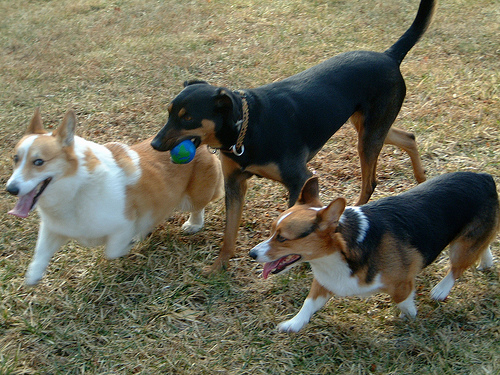

In [22]:
tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

model = load_model('model.h5')

#img = "./Flickr_Data/Images/143552697_af27e9acf5.jpg"
#img = "./Flickr_Data/Images/1453366750_6e8cf601bf.jpg"

#crawled img from flickr.com
img = "D:/XAMPP/htdocs/Package/Image_Retrieval/Images/2239938351_43c73c887c.jpg"

photo = extract_features(img)
#print(photo.shape)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n",description,"\n\n")

z = Image(filename=img)
display(z)